In [1]:
import pandas as pd
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import json
from pathlib import Path
from kneed import KneeLocator
import numpy as np
import rasterio as rio
from tqdm import tqdm 
import seaborn as sns 

# font_path = '/home/dhester/.fonts/InterVariable.ttf'
font_path = r"C:\Users\dh2306\AppData\Local\Microsoft\Windows\Fonts\Inter-VariableFont_opsz,wght.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.style.use('seaborn-v0_8-darkgrid')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [2]:
cms = []
dfs = []
per_class_metrics_dfs = []
for dir in glob('../runs/s2flow_lc_model_sweep/20251201_*/*/*/*/*/*'):
    dir = Path(dir)
    # print(dir)
    # # continue
    path_parts = dir.parts
    
    model = path_parts[4]
    data = path_parts[5]
    fold = path_parts[6].split('_')[-1]
    
    if dir.name == 'lc_confusion_matrix.csv':
        cm = pd.read_csv(dir)
        cm['model'] = model
        cm['data'] = data
        cm['fold'] = fold
        cms.append(cm)
    
    if dir.name == 'lc_per_class_metrics.csv':
        per_class_metrics = pd.read_csv(dir)
        per_class_metrics['model'] = model
        per_class_metrics['data'] = data
        per_class_metrics['fold'] = fold
        per_class_metrics_dfs.append(per_class_metrics)
    
    elif dir.name == 'lc_summary_metrics.csv':
        df = pd.read_csv(dir)
        df['model'] = model
        df['data'] = data
        df['fold'] = fold
        dfs.append(df)
    
    else: 
        continue
metrics_df = pd.concat(dfs, ignore_index=True)
per_class_metrics_df = pd.concat(per_class_metrics_dfs, ignore_index=True)
cm_df = pd.concat(cms, ignore_index=False)

In [3]:
per_class_metrics_df.pivot_table(
    index=['model', 'data', 'fold'],
    values=['precision', 'recall', 'f1_score'],
    columns=['class_id']
).groupby(['model', 'data']).mean()

f1_score                                          \
class_id                   1         2         3         4         5   
model         data                                                     
deeplabv3plus naip  0.970372  0.891077  0.961802  0.738426  0.457104   
              s2    0.968648  0.876599  0.956657  0.659093  0.411460   
segformer     naip  0.970959  0.894058  0.962657  0.744713  0.473484   
              s2    0.969291  0.878997  0.957546  0.671762  0.419350   
unet          naip  0.969101  0.892939  0.961875  0.763989  0.458251   
              s2    0.966765  0.872625  0.954872  0.648905  0.397278   

                   precision                                          \
class_id                   1         2         3         4         5   
model         data                                                     
deeplabv3plus naip  0.982217  0.902257  0.955222  0.754066  0.588739   
              s2    0.980992  0.886727  0.949758  0.684906  0.586023   
segformer     naip  0.980335  0.900702  0.958497  0.751615  0.580175   
              s2    0.979115  0.887537  0.952143  0.683464  0.555280   
unet          naip  0.980035  0.905397  0.955236  0.770844  0.581021   
              s2    0.978431  0.883052  0.948001  0.669974  0.587081   

                      recall                                          
class_id                   1         2         3         4         5  
model         data                                                    
deeplabv3plus naip  0.958813  0.880172  0.968473  0.723435  0.373609  
              s2    0.956611  0.866703  0.963658  0.635168  0.317613  
segformer     naip  0.961761  0.887510  0.966853  0.737938  0.400242  
              s2    0.959664  0.870621  0.963011  0.660458  0.337219  
unet          naip  0.958410  0.880826  0.968609  0.757280  0.378982  
              s2    0.955376  0.862461  0.961847  0.629133  0.300447

In [4]:
cm_df

,Unnamed: 0,pred_1,pred_2,pred_3,pred_4,pred_5,model,data,fold
0,true_1,10825241,286996,148503,7273,7428,deeplabv3plus,naip,0
1,true_2,126713,88686629,10338376,1336438,205122,deeplabv3plus,naip,0
2,true_3,65429,7313058,243359378,597071,34474,deeplabv3plus,naip,0
3,true_4,9533,1507755,715896,6079597,49671,deeplabv3plus,naip,0
4,true_5,7141,526925,111248,75291,413118,deeplabv3plus,naip,0
...,...,...,...,...,...,...,...,...,...
0,true_1,10793726,251134,210139,13023,7419,unet,s2,4
1,true_2,130150,86791136,11926185,1693954,151853,unet,s2,4
2,true_3,82067,8239626,242297604,726793,23320,unet,s2,4
3,true_4,11616,1977978,1019517,5316296,37045,unet,s2,4


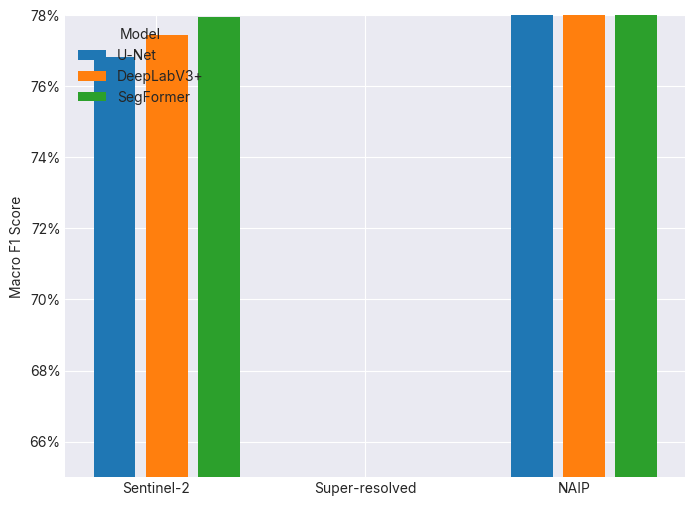

In [5]:
f1_data = metrics_df[['model', 'data', 'macro_f1']].groupby(['model', 'data']).mean().reset_index()

f1_data['data'] = f1_data['data'].map({
    'naip': 'NAIP',
    's2': 'Sentinel-2',
    's2sr': 'Super-resolved'
})
f1_data['data'] = pd.Categorical(f1_data['data'], categories=[ 'Sentinel-2', 'Super-resolved', 'NAIP'], ordered=True)

f1_data['model'] = f1_data['model'].map({
    'deeplabv3plus': 'DeepLabV3+',
    'unet': 'U-Net',
    'segformer': 'SegFormer'
})
f1_data['model'] = pd.Categorical(f1_data['model'], categories=['U-Net', 'DeepLabV3+', 'SegFormer'], ordered=True)

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.2
offset = -bar_width
gap = 0.05
x_col = 'data'
hue_col = 'model'

for i, model in enumerate(f1_data[hue_col].cat.categories):
    model_data = f1_data[f1_data[hue_col] == model]
    x = model_data[x_col].cat.codes + offset + i * (bar_width + gap)
    ax.bar(x, model_data['macro_f1'], width=bar_width, label=model)
    
ax.set_xticks(range(len(f1_data[x_col].cat.categories)))
ax.set_xticklabels(f1_data[x_col].cat.categories)

ax.set_ylabel('Macro F1 Score')
# ax.set_title('Macro F1 Score by Model and Data Type')
ax.legend(title='Model', loc='upper left')

ax.set_ylim(0.65, .78)
# use percent format for y axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))    

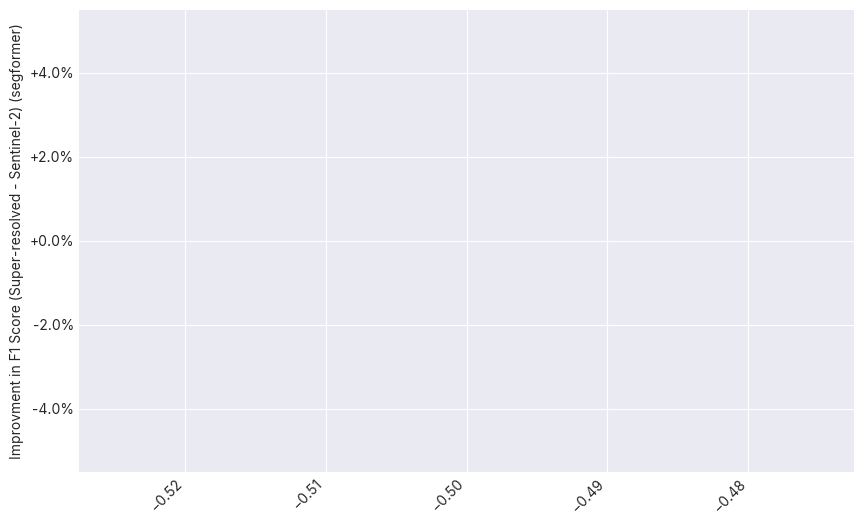

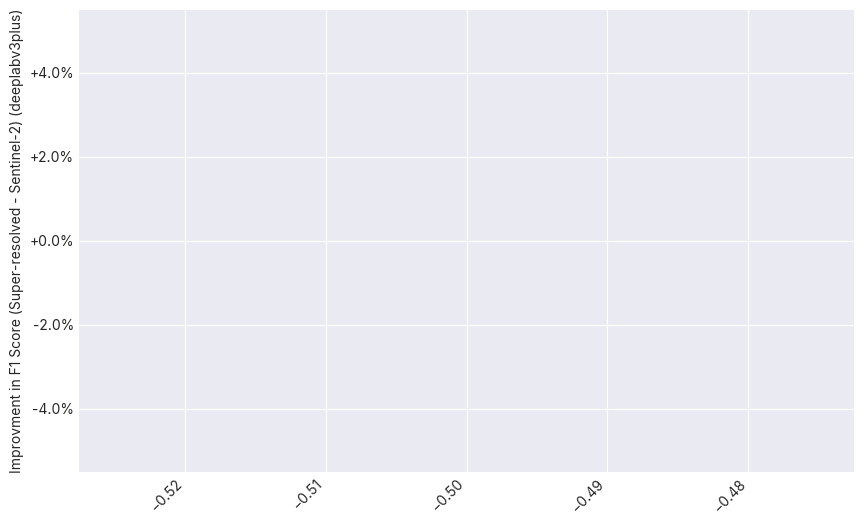

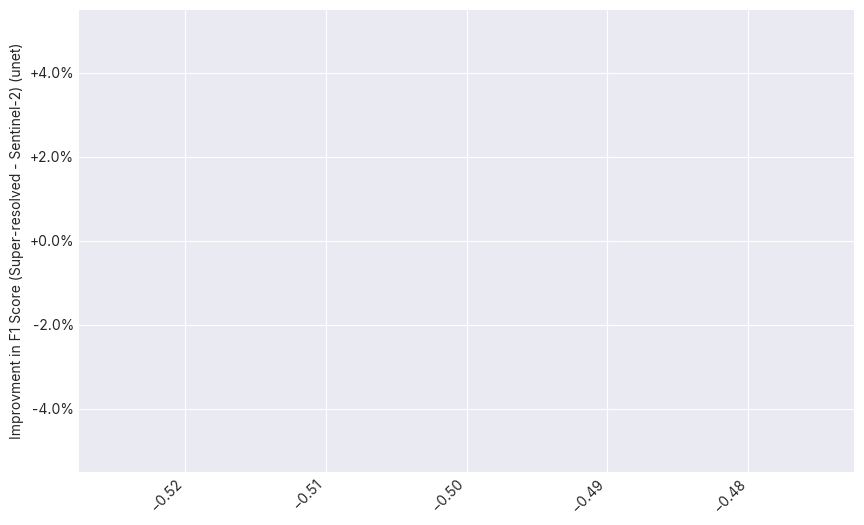

In [6]:
# for segformer  model only, create bar plot showing class-wise changes in f1 score between s2 and s2sr
# e.g., class 1 : +.25, class 2: -0.1, etc.

cpb_colormap_consistent = {
    0: (0, 0, 0, 0),          # Nodata: Transparent (overrides #ffffff for GIS best practices)
    1: (81, 108, 151, 255),   # Open Water: #516c97
    2: (255, 0, 0, 255),      # Impervious Structures: #FF0000
    3: (152, 152, 153, 255),  # Impervious Surfaces: #989899
    4: (74, 37, 20, 255),     # Barren Land: #4a2514
    5: (55, 120, 78, 255),    # Tree Canopy/Woody Vegetation: #37784e
    6: (179, 253, 214, 255),  # Low Vegetation/Herbaceous: #b3fdd6
    7: (246, 180, 76, 255),   # Cultivated Crops: #f6b44c
    8: (0, 0, 0, 255)         # Unclassified: #000000
}

for model in ['segformer', 'deeplabv3plus', 'unet']:
    segformer_data = per_class_metrics_df[per_class_metrics_df['model'] == model]
    s2_data = segformer_data[segformer_data['data'] == 's2']
    s2sr_data = segformer_data[segformer_data['data'] == 's2sr']
    merged_data = pd.merge(
        s2_data,
        s2sr_data,
        on=['class_id', 'fold'],
        suffixes=('_s2', '_s2sr')
    )
    merged_data['f1_diff'] = merged_data['f1_score_s2sr'] - merged_data['f1_score_s2']
    f1_diff_data = merged_data.groupby('class_id')['f1_diff'].mean().reset_index()
    
    class_labels = {
        1: 'Open Water',
        2: 'Impervious Structure',
        3: 'Impervious Surface',
        4: 'Barren Land',
        5: 'Tree Canopy/Woody Vegetation',
        6: 'Low Vegetation/Herbaceous',
        7: 'Cultivated Crops',
    }
    f1_diff_data['class_label'] = f1_diff_data['class_id'].map(class_labels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(f1_diff_data['class_label'], f1_diff_data['f1_diff'], color=[
        np.array(cpb_colormap_consistent[cid]) / 255.0 for cid in f1_diff_data['class_id']
    ], edgecolor='black')
    ax.hlines(0, -0.5, len(f1_diff_data['class_label']) - 0.5, colors='gray', linestyles='dashed')
    ax.set_ylabel(f'Improvment in F1 Score (Super-resolved - Sentinel-2) ({model})')
    # rotate x labels
    plt.xticks(rotation=45, ha='right')
    
    # format y axis as percent
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:+.1%}'.format(y)))
    


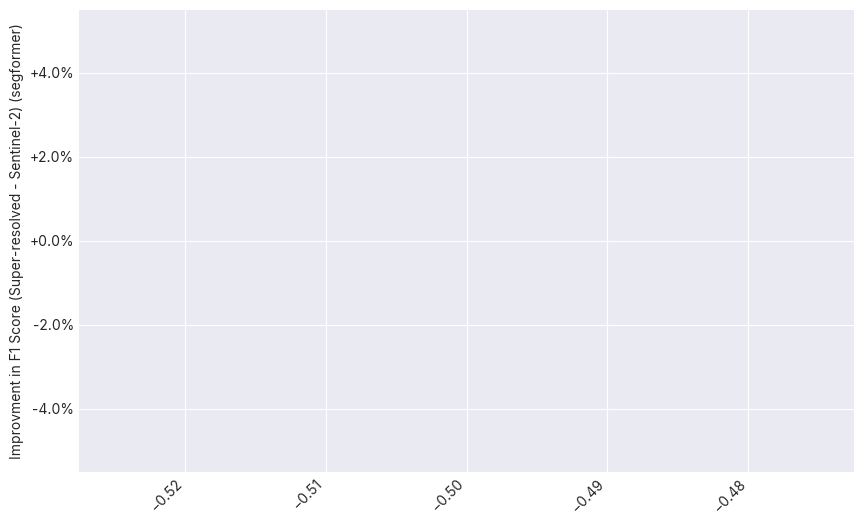

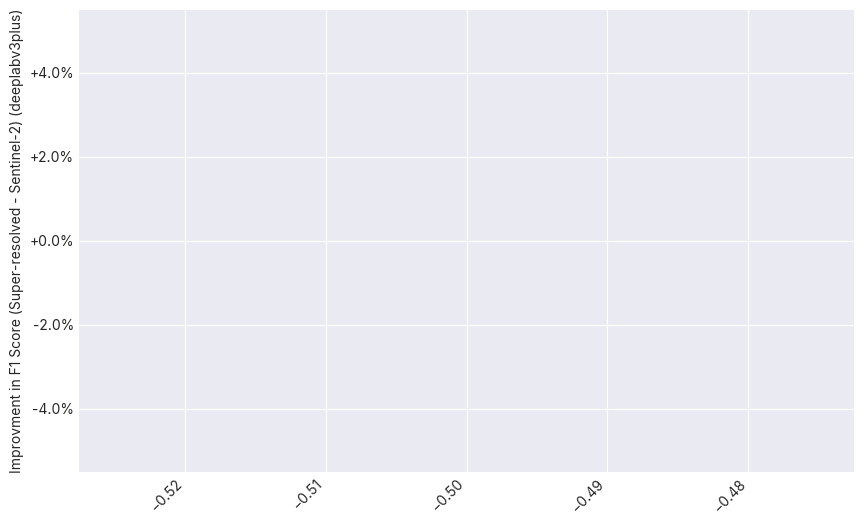

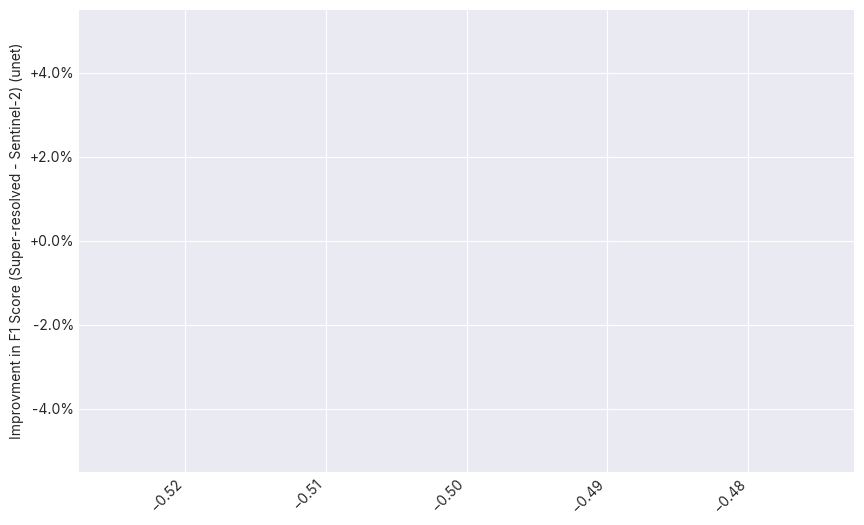

In [7]:
# for segformer  model only, create bar plot showing class-wise changes in f1 score between s2 and s2sr
# e.g., class 1 : +.25, class 2: -0.1, etc.

cpb_colormap_consistent = {
    0: (0, 0, 0, 0),          # Nodata: Transparent (overrides #ffffff for GIS best practices)
    1: (81, 108, 151, 255),   # Open Water: #516c97
    2: (255, 0, 0, 255),      # Impervious Structures: #FF0000
    3: (152, 152, 153, 255),  # Impervious Surfaces: #989899
    4: (74, 37, 20, 255),     # Barren Land: #4a2514
    5: (55, 120, 78, 255),    # Tree Canopy/Woody Vegetation: #37784e
    6: (179, 253, 214, 255),  # Low Vegetation/Herbaceous: #b3fdd6
    7: (246, 180, 76, 255),   # Cultivated Crops: #f6b44c
    8: (0, 0, 0, 255)         # Unclassified: #000000
}

for model in ['segformer', 'deeplabv3plus', 'unet']:
    segformer_data = per_class_metrics_df[per_class_metrics_df['model'] == model]
    naip_data = segformer_data[segformer_data['data'] == 'naip']
    s2sr_data = segformer_data[segformer_data['data'] == 's2sr']
    merged_data = pd.merge(
        naip_data,
        s2sr_data,
        on=['class_id', 'fold'],
        suffixes=('_naip', '_s2sr')
    )
    merged_data['f1_diff'] =  merged_data['f1_score_naip'] - merged_data['f1_score_s2sr']
    f1_diff_data = merged_data.groupby('class_id')['f1_diff'].mean().reset_index()
    
    class_labels = {
        1: 'Open Water',
        2: 'Impervious Structure',
        3: 'Impervious Surface',
        4: 'Barren Land',
        5: 'Tree Canopy/Woody Vegetation',
        6: 'Low Vegetation/Herbaceous',
        7: 'Cultivated Crops',
    }
    f1_diff_data['class_label'] = f1_diff_data['class_id'].map(class_labels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(f1_diff_data['class_label'], f1_diff_data['f1_diff'], color=[
        np.array(cpb_colormap_consistent[cid]) / 255.0 for cid in f1_diff_data['class_id']
    ], edgecolor='black')
    ax.hlines(0, -0.5, len(f1_diff_data['class_label']) - 0.5, colors='gray', linestyles='dashed')
    ax.set_ylabel(f'Improvment in F1 Score (Super-resolved - Sentinel-2) ({model})')
    # rotate x labels
    plt.xticks(rotation=45, ha='right')
    
    # format y axis as percent
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:+.1%}'.format(y)))
    


C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\692950950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_data['data'] = boxplot_data['data'].map({
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\692950950.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_data['data'] = pd.Categorical(boxplot_data['data'], categories=['Super-resolved', 'Sentinel-2', 'NAIP'], ordered=True)
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\692950950.py:11: SettingWithCopyWarning: 
A value is tryin

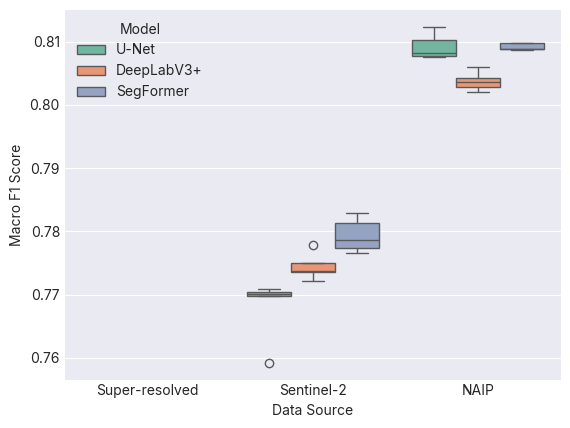

In [8]:
# create boxplot 

boxplot_data = metrics_df[['model', 'data', 'macro_f1']]
boxplot_data['data'] = boxplot_data['data'].map({
    'naip': 'NAIP',
    's2': 'Sentinel-2',
    's2sr': 'Super-resolved'
})
boxplot_data['data'] = pd.Categorical(boxplot_data['data'], categories=['Super-resolved', 'Sentinel-2', 'NAIP'], ordered=True)

boxplot_data['model'] = boxplot_data['model'].map({
    'deeplabv3plus': 'DeepLabV3+',
    'unet': 'U-Net',
    'segformer': 'SegFormer'
})
boxplot_data['model'] = pd.Categorical(boxplot_data['model'], categories=['U-Net', 'DeepLabV3+', 'SegFormer'], ordered=True)

ax = sns.boxplot(
    data=boxplot_data,
    x='data',
    y='macro_f1',
    hue='model',
    palette='Set2',
)

ax.set_xlabel('Data Source')
ax.set_ylabel('Macro F1 Score')

ax.legend(title='Model', loc='upper left')

In [9]:
dlv3p_df = cm_df.loc[cm_df['model'] == 'deeplabv3plus'].copy()
dlv3p_df['class_id'] = dlv3p_df['Unnamed: 0'].map(lambda x: int(x.split('_')[-1]))
dlv3p_df = dlv3p_df.drop(columns=['Unnamed: 0', 'model'])
dlv3p_df['fold'] = dlv3p_df['fold'].astype(int)

dlv3p_df.groupby(['data']).mean()

,pred_1,pred_2,pred_3,pred_4,pred_5,fold,class_id
data,,,,,,,
naip,2201360.16,19645743.16,50971300.32,1604574.08,143883.08,2.0,3.0
s2,2199041.84,19683932.08,51009692.56,1551054.48,123139.84,2.0,3.0


In [10]:
import xarray as xr

cm_arr = cm_df.set_index(['model', 'data', 'fold', 'Unnamed: 0']).to_xarray()


In [11]:
# visualize average confusion matrix for each model and data type
cm_means_ds = cm_arr.mean(dim='fold')
for model in cm_means_ds.model.values:
    for data in cm_means_ds.data.values:
        print(f"Confusion Matrix for {model} on {data} data:")
        display(cm_means_ds.sel(model=model, data=data).to_dataframe()) 

Confusion Matrix for deeplabv3plus on naip data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10811042.2,298071.2,150613.4,7506.0,8208.2,deeplabv3plus,naip
true_2,118432.4,88627454.2,10431928.8,1308293.0,207169.6,deeplabv3plus,naip
true_3,62364.4,7248903.6,243444501.2,579967.2,33673.6,deeplabv3plus,naip
true_4,9269.2,1537110.8,719585.0,6049692.2,46794.8,deeplabv3plus,naip
true_5,5692.6,517176.0,109873.2,77412.0,423569.2,deeplabv3plus,naip


Confusion Matrix for deeplabv3plus on s2 data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10786210.4,267733.4,202107.6,12603.8,6785.8,deeplabv3plus,s2
true_2,116023.8,87271126.6,11510018.8,1612181.4,183927.4,deeplabv3plus,s2
true_3,76550.2,8317970.0,242234042.6,712711.0,28136.2,deeplabv3plus,s2
true_4,10366.2,2019725.2,984037.2,5311558.8,36764.6,deeplabv3plus,s2
true_5,6058.6,543105.2,118256.6,106217.4,360085.2,deeplabv3plus,s2


Confusion Matrix for segformer on naip data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10844279.4,278579.2,134931.0,7131.2,10520.2,segformer,naip
true_2,131072.4,89366325.2,9626859.6,1333706.6,235314.2,segformer,naip
true_3,70535.8,7610976.8,243037163.2,614067.8,36666.4,segformer,naip
true_4,9422.8,1470092.6,665269.8,6170975.0,46691.8,segformer,naip
true_5,6504.4,492531.2,96495.0,84428.6,453763.8,segformer,naip


Confusion Matrix for segformer on s2 data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10820633.6,255953.4,180383.0,11164.2,7306.8,segformer,s2
true_2,131399.4,87665707.8,11002721.0,1673172.2,220277.6,segformer,s2
true_3,82672.4,8405903.6,242071416.6,773901.2,35516.2,segformer,s2
true_4,9791.6,1911153.0,874677.2,5523046.6,43783.6,segformer,s2
true_5,6960.6,535481.6,109239.8,99727.6,382313.4,segformer,s2


Confusion Matrix for unet on naip data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10806500.4,288656.8,157133.0,12978.6,10172.2,unet,naip
true_2,123330.6,88693294.4,10461456.4,1198323.4,216873.2,unet,naip
true_3,80864.6,7191109.2,243478703.4,582386.2,36346.6,unet,naip
true_4,9957.2,1293698.4,677623.8,6332718.4,48454.2,unet,naip
true_5,6048.6,494919.4,113884.6,89210.0,429660.4,unet,naip


Confusion Matrix for unet on s2 data:


,pred_1,pred_2,pred_3,pred_4,pred_5,model,data
Unnamed: 0,,,,,,,
true_1,10772280.6,264307.4,217823.6,13247.8,7781.6,unet,s2
true_2,120968.8,86844010.8,11894851.2,1669668.6,163778.6,unet,s2
true_3,97828.0,8667354.4,241778936.2,796704.8,28586.6,unet,s2
true_4,10664.8,2026736.0,1023900.2,5261096.2,40054.8,unet,s2
true_5,8040.6,547283.8,125262.4,112512.4,340623.8,unet,s2


In [12]:
naip_out_paths = glob('../runs/s2flow_lc_model_sweep/20251201_084013/segformer/naip/fold_2/s2flow_lc_segformer_naip_fold2/lc_outputs/*.tif')

cmap = None
def colorize_landcover(array, colormap):
    """Apply a colormap to a landcover array."""

    # Create an RGB image
    rgb_image = np.zeros((array.shape[0], array.shape[1], 3), dtype=np.uint8)
    
    for class_id, color in colormap.items():
        mask = array == class_id
        rgb_image[mask] = color[:3]  # Ignore alpha if present
    
    return rgb_image

data = {
    'pid': [],
    'naip': [],
    's2': [],
    's2sr': [],
    'naip_pred': [],
    's2_pred': [],
    's2sr_pred': [],
    'gt': []
}

num_samples = 5
with tqdm(total=num_samples) as pbar:
    for naip_out_path in naip_out_paths:
        
        if len(data['pid']) >= num_samples:
            break
    
        pid = os.path.basename(naip_out_path).strip('.tif')
        if pid in ['00500', '00101', '00094', '00975']:
            continue
        
        naip_input_path = rf"D:\chesapeake_bay_2022_2024edition\samples\naip\{pid}.tif"
        s2_input_path = rf"D:\chesapeake_bay_2022_2024edition\samples\sentinel2\{pid}.tif"
        s2_sr_input_path = rf"D:\chesapeake_bay_2022_2024edition\samples\sentinel2_sr_steps_1\{pid}.tif"
        gt_path = rf"D:\chesapeake_bay_2022_2024edition\samples\landcover_adj\{pid}.tif"
        
        assert os.path.exists(naip_input_path), f"NAIP input file not found: {naip_input_path}"
        assert os.path.exists(s2_input_path), f"S2 input file not found: {s2_input_path}"
        assert os.path.exists(s2_sr_input_path), f"S2 SR input file not found: {s2_sr_input_path}"
        assert os.path.exists(gt_path), f"GT file not found: {gt_path}"
        
        s2_out_path = naip_out_path.replace('naip', 's2')
        # s2_sr_out_path = naip_out_path.replace('naip', 's2sr')
        s2_sr_out_path = f'../runs/s2flow_lc_sampling_steps_sweep/steps_1/segformer/fold_2/lc_step1_segformer_f2/lc_outputs/{pid}.tif'
        
        assert os.path.exists(s2_out_path), f"S2 output file not found: {s2_out_path}"
        assert os.path.exists(s2_sr_out_path), f"S2 SR output file not found: {s2_sr_out_path}"
        
        with rio.open(gt_path) as src:
            gt_raw = src.read(1)
            if cmap is None:
                cmap = src.colormap(1)
            
        # if np.unique(gt_raw).size < 3:
            # continue
        if np.sum(gt_raw == 4) < 20000:
            continue
        # if np.sum(gt_raw == 2) < 1000 or np.sum(gt_raw == 3) < 400:
            # continue
        
        data['gt'].append(colorize_landcover(gt_raw, cmap))
        
        with rio.open(naip_input_path) as src:
            data['naip'].append(src.read((1, 2, 3)))
        
        with rio.open(s2_input_path) as src:
            data['s2'].append(src.read((1, 2, 3)))
        
        with rio.open(s2_sr_input_path) as src:
            data['s2sr'].append(src.read((1, 2, 3)))
        
        with rio.open(naip_out_path) as src:
            data['naip_pred'].append(colorize_landcover(src.read(1), cmap))
        
        with rio.open(s2_out_path) as src:
            data['s2_pred'].append(colorize_landcover(src.read(1), cmap))
        
        with rio.open(s2_sr_out_path) as src:
            data['s2sr_pred'].append(colorize_landcover(src.read(1), cmap))
        
        data['pid'].append(pid)
        
        pbar.update(1)

100%|██████████| 5/5 [00:34<00:00,  6.91s/it]


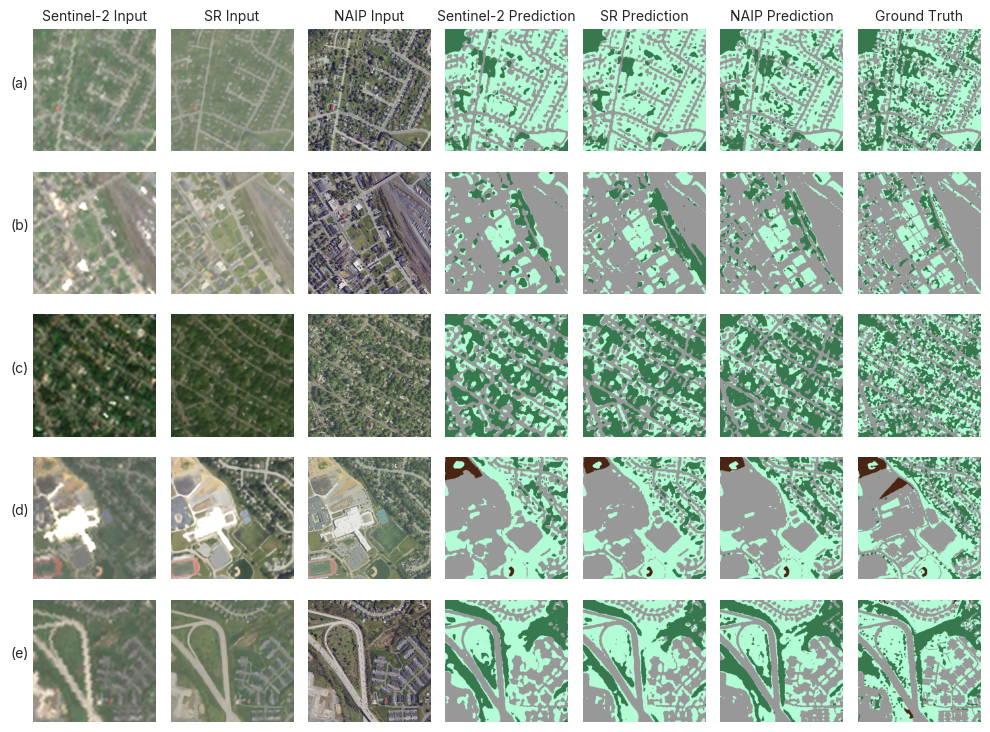

In [13]:
gains = [
    3,
    3,
    5,
    2.5,
    2.5
]

fig, ax = plt.subplots(num_samples, 7, figsize=(10, num_samples * 1.5))
for i in range(num_samples):
    
    # s2 input
    s2_img = np.transpose(data['s2'][i], (1, 2, 0)) / (10000 / gains[i])
    s2_img = np.clip(s2_img, 0, 1)
    ax[i, 0].imshow(s2_img)
    
    # s2 output
    ax[i, 3].imshow(data['s2_pred'][i])
    
    # s2sr input
    s2sr_img = np.transpose(data['s2sr'][i], (1, 2, 0)) / (10000 / gains[i])
    s2sr_img = np.clip(s2sr_img, 0, 1)
    ax[i, 1].imshow(s2sr_img)
    
    # s2sr output
    ax[i, 4].imshow(data['s2sr_pred'][i])
    
    # naip input
    naip_img = np.transpose(data['naip'][i], (1, 2, 0)) / 255
    naip_img = np.clip(naip_img, 0, 1)
    ax[i, 2].imshow(naip_img)
    
    # naip output
    ax[i, 5].imshow(data['naip_pred'][i])
    
    # gt
    ax[i, 6].imshow(data['gt'][i])
    
    for j in range(1, 7):
        ax[i, j].axis('off')
    
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    # label (a) - (g) for each column
    ax[i, 0].set_ylabel(f'({chr(97 + i)})', rotation=0, labelpad=10)
    
    title_font_size = 10
    if i == 0:
        
        ax[i, 0].set_title('Sentinel-2 Input', fontsize=title_font_size)
        ax[i, 3].set_title('Sentinel-2 Prediction', fontsize=title_font_size)
        ax[i, 1].set_title('SR Input', fontsize=title_font_size)
        ax[i, 4].set_title('SR Prediction', fontsize=title_font_size)
        ax[i, 2].set_title('NAIP Input', fontsize=title_font_size)
        ax[i, 5].set_title('NAIP Prediction', fontsize=title_font_size)
        ax[i, 6].set_title('Ground Truth', fontsize=title_font_size)

# fig.suptitle('U-Net Inference')
fig.tight_layout() # makes sup title overlap with subplots

# adjust layout to make room for suptitle
# fig.subplots_adjust(top=0.97)
fig_dir = '../figures/inference_examples/'
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, 'lc_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'lc_model_comparison.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig('lc_model_comparison.png', dpi=300)

In [14]:
# show how # of sampling steps affects land cover classification accuracy
# idea - more sampling steps = better super-resolution = better land cover classification,
# in truth, more sampling steps = more hallucinations = worse land cover classification

dfs = []
for csv_file in glob('../runs/s2flow_lc_sampling_steps_sweep/*/*/*/*/lc_summary_metrics.csv'):
    path_parts = Path(csv_file).parts
    # for i, part in enumerate(path_parts):
        # print(f"Part {i}: {part}")
    steps = path_parts[3].split('_')[-1]
    model = path_parts[4]
    fold = path_parts[5].split('_')[-1]
    
    df = pd.read_csv(csv_file)
    df['steps'] = int(steps)
    df['model'] = model
    df['fold'] = fold
    dfs.append(df)

steps_metrics_df = pd.concat(dfs, ignore_index=True)


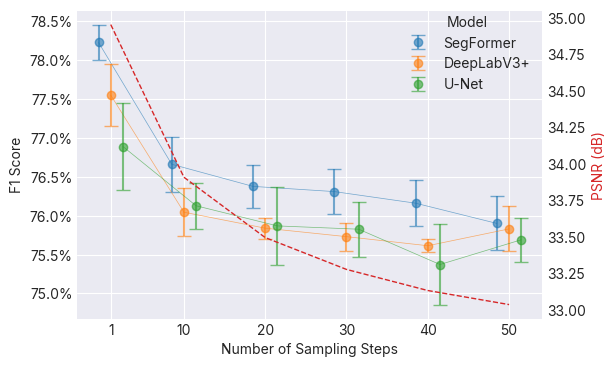

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))
models = ['segformer', 'deeplabv3plus', 'unet']
fancy_model_names = {
    'segformer': 'SegFormer',
    'deeplabv3plus': 'DeepLabV3+',
    'unet': 'U-Net'
}
offset_dist = 1.5
alpha = 0.6
linewidth = 0.5

psnr_dict = {
    1: 34.95354992024442,
    10: 33.90724321026752,
    20: 33.49367841349003,
    30: 33.27537321632213,
    40: 33.130858922258334,
    50: 33.034415834127586,
}

ax2 = ax.twinx()
ax2.plot(list(psnr_dict.keys()), list(psnr_dict.values()), linestyle='--', color='C3', linewidth=2*linewidth)
ax2.set_ylabel('PSNR (dB)', color='C3')

for i, model in enumerate(models):
    model_data = steps_metrics_df[steps_metrics_df['model'] == model]
    mean_f1 = model_data.groupby('steps')['macro_f1'].mean().reset_index()
    # add offset to x values based on model index
    
    ax.plot(mean_f1['steps'] + ((i - 1) * offset_dist) , mean_f1['macro_f1'],  color=f'C{i}', alpha=alpha, linewidth=linewidth)
    # add error bars showing std dev
    std_f1 = model_data.groupby('steps')['macro_f1'].std().reset_index()
    ax.errorbar(mean_f1['steps'] + ((i - 1) * offset_dist) , mean_f1['macro_f1'], yerr=std_f1['macro_f1'], fmt='o', capsize=5, color=f'C{i}', alpha=alpha, label=fancy_model_names[model],)

ax.set_xlabel('Number of Sampling Steps')
ax.set_xticks([1, 10, 20, 30, 40, 50])
ax.set_ylabel('F1 Score')
# use percent format for y axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

fig.legend(title='Model', loc='upper right', bbox_to_anchor=(0.9, 0.9))

# ax2.tick_params(axis='y', labelcolor='C3')
ax2.yaxis.grid(False)

fig_dir = Path('../figures/lc_model_vs_psnr/')
for filetype in ['png', 'pdf']:
    
    fig_dir.mkdir(parents=True, exist_ok=True)
    out_path = fig_dir / f'lc_model_vs_psnr.{filetype}'
    plt.savefig(out_path, dpi=300, bbox_inches='tight')

C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3005420741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_data['data'] = boxplot_data['data'].map({
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3005420741.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_data['data'] = pd.Categorical(boxplot_data['data'], categories=['Sentinel-2', 'Super-resolved', 'NAIP'], ordered=True)
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3005420741.py:15: SettingWithCopyWarning: 
A value is t

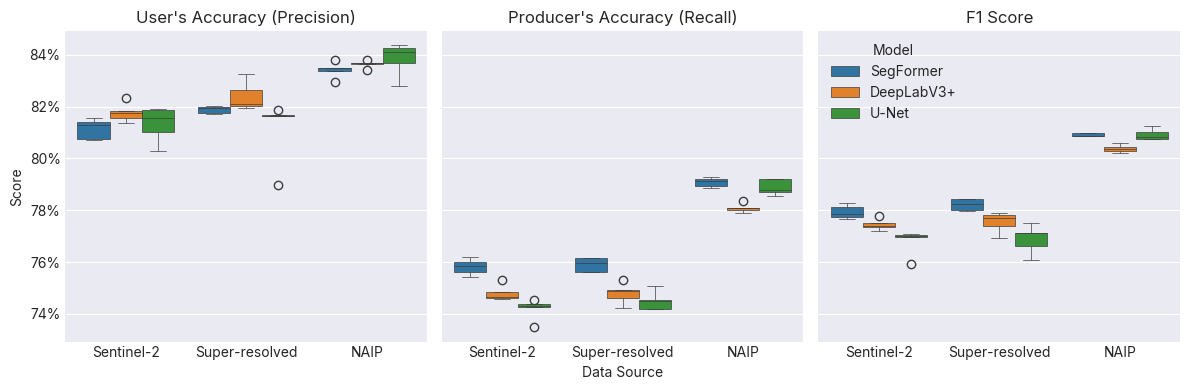

In [16]:
steps_1_metrics_df = steps_metrics_df.loc[steps_metrics_df['steps'] == 1].drop(columns=['steps'])
steps_1_metrics_df['data'] = 's2sr'
metrics_df_all = pd.concat([metrics_df, steps_1_metrics_df], ignore_index=True)

# create boxplot 

boxplot_data = metrics_df_all[['model', 'data', 'macro_f1', 'macro_precision', 'macro_recall']]
boxplot_data['data'] = boxplot_data['data'].map({
    'naip': 'NAIP',
    's2sr': 'Super-resolved',
    's2': 'Sentinel-2',
})
boxplot_data['data'] = pd.Categorical(boxplot_data['data'], categories=['Sentinel-2', 'Super-resolved', 'NAIP'], ordered=True)

boxplot_data['model'] = boxplot_data['model'].map({
    'segformer': 'SegFormer',
    'deeplabv3plus': 'DeepLabV3+',
    'unet': 'U-Net',
})
boxplot_data['model'] = pd.Categorical(boxplot_data['model'], categories=['SegFormer', 'DeepLabV3+', 'U-Net'], ordered=True)


fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

linewidth = 0.5
sns.boxplot(
    data=boxplot_data,
    x='data',
    y='macro_precision',
    hue='model',
    linewidth=linewidth,
    ax=ax[0],
    legend=False,
    # palette='Set2',
)

sns.boxplot(
    data=boxplot_data,
    x='data',
    y='macro_recall',
    hue='model',
    linewidth=linewidth,
    ax=ax[1],
    legend=False,
    # palette='Set2',
)

sns.boxplot(
    data=boxplot_data,
    x='data',
    y='macro_f1',
    hue='model',
    linewidth=linewidth,
    ax=ax[2],
)

ax[0].set_xlabel('')
ax[1].set_xlabel('Data Source')
ax[2].set_xlabel('')


ax[0].set_title('User\'s Accuracy (Precision)')
ax[1].set_title('Producer\'s Accuracy (Recall)')
ax[2].set_title('F1 Score')

ax[0].set_ylabel('Score')
ax[0].set_yticklabels(['{:.0%}'.format(y) for y in ax[0].get_yticks()])

ax[2].legend(title='Model', loc='upper left')
fig.tight_layout()

fig_dir = '../figures/model_scores/'
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, 'lc_model_scores_boxplots.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'lc_model_scores_boxplots.pdf'), dpi=300, bbox_inches='tight')

C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3592273107.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.pointplot(
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3592273107.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\3592273107.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  ax = sns.pointplot(


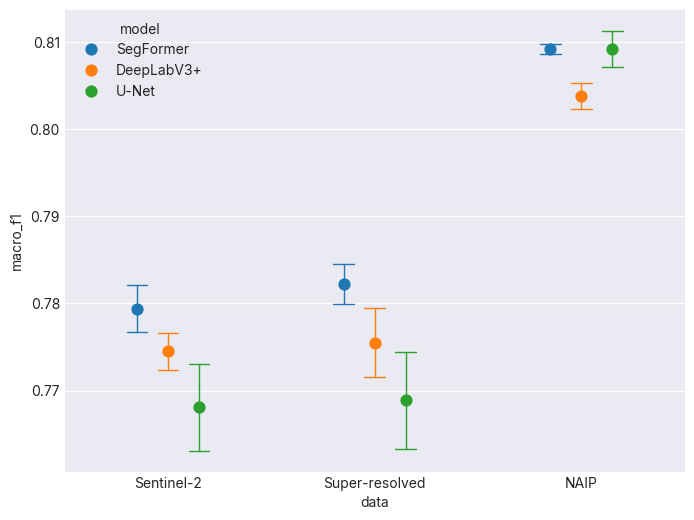

In [17]:
# show the means only
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.pointplot(
    data=boxplot_data,
    x='data',
    y='macro_f1',
    hue='model',
    dodge=0.3,
    join=False,
    markers='o',
    capsize=0.1,
    errwidth=1,
    ci='sd',
    ax=ax
)

In [18]:
dfs = []
for csv_file in glob('../runs/s2flow_lc_sampling_steps_sweep/steps_1/*/*/*/lc_per_class_metrics.csv'):
    path_parts = Path(csv_file).parts
    steps = path_parts[3].split('_')[-1]
    model = path_parts[4]
    fold = path_parts[5].split('_')[-1]
    
    df = pd.read_csv(csv_file)
    # df['steps'] = int(steps)
    df['model'] = model
    df['fold'] = fold
    dfs.append(df)

sr_per_class_metrics_df = pd.concat(dfs, ignore_index=True)
sr_per_class_metrics_df['data'] = 's2sr'
per_class_metrics_all_df = pd.concat([per_class_metrics_df, sr_per_class_metrics_df], ignore_index=True)

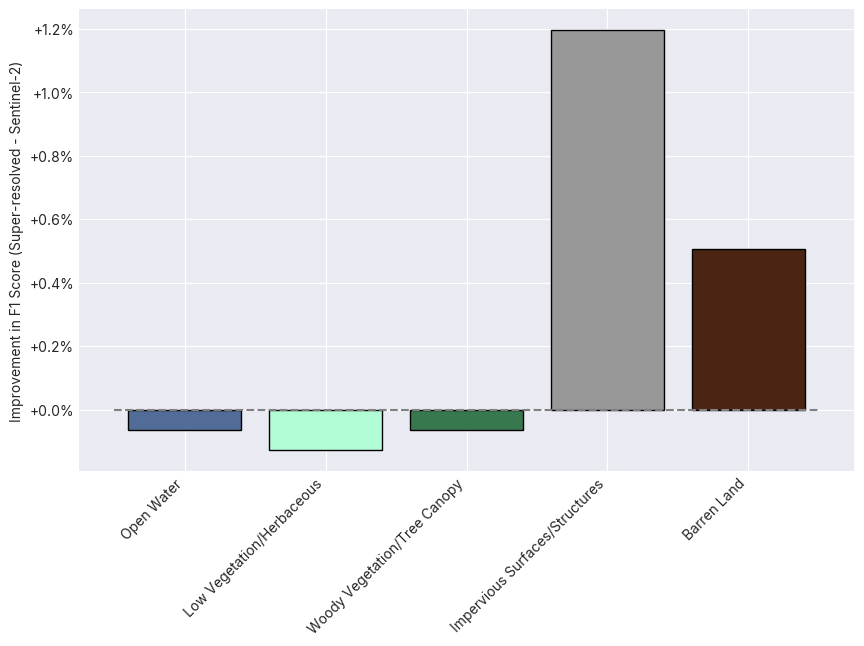

In [19]:
# for segformer  model only, create bar plot showing class-wise changes in f1 score between s2 and s2sr
# e.g., class 1 : +.25, class 2: -0.1, etc.

cpb_colormap_consistent = {
    0: (0, 0, 0, 0),          # Nodata: Transparent (overrides #ffffff for GIS best practices)
    1: (81, 108, 151, 255),   # Open Water: #516c97
    2: (179, 253, 214, 255),  # Low Vegetation/Herbaceous: #b3fdd6
    3: (55, 120, 78, 255),    # Woody Vegetation/Tree Canopy: #37784e
    4: (152, 152, 153, 255),  # Impervious Surfaces/Structures: #989899
    5: (74, 37, 20, 255),     # Barren Land: #4a2514
}

for model in ['segformer']:
    segformer_data = per_class_metrics_all_df[per_class_metrics_all_df['model'] == model]
    s2_data = segformer_data[segformer_data['data'] == 's2']
    s2sr_data = segformer_data[segformer_data['data'] == 's2sr']
    merged_data = pd.merge(
        s2_data,
        s2sr_data,
        on=['class_id', 'fold'],
        suffixes=('_s2', '_s2sr')
    )
    merged_data['f1_diff'] = -( merged_data['f1_score_s2'] - merged_data['f1_score_s2sr'])
    f1_diff_data = merged_data.groupby('class_id')['f1_diff'].mean().reset_index()
    
    class_labels = {
        1: 'Open Water',
        2: 'Low Vegetation/Herbaceous',
        3: 'Woody Vegetation/Tree Canopy',
        4: 'Impervious Surfaces/Structures',
        5: 'Barren Land',
    }
    f1_diff_data['class_label'] = f1_diff_data['class_id'].map(class_labels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(f1_diff_data['class_label'], f1_diff_data['f1_diff'], color=[
        np.array(cpb_colormap_consistent[cid]) / 255.0 for cid in f1_diff_data['class_id']
    ], edgecolor='black')
    ax.hlines(0, -0.5, len(f1_diff_data['class_label']) - 0.5, colors='gray', linestyles='dashed')
    ax.set_ylabel(f'Improvement in F1 Score (Super-resolved - Sentinel-2)')
    # rotate x labels
    plt.xticks(rotation=45, ha='right')
    
    # format y axis as percent
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:+.1%}'.format(y)))
    


C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\2521487580.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(f1_diff_data['class_label'], rotation=30, ha='center')
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\2521487580.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(f1_diff_data['class_label'], rotation=30, ha='center')
C:\Users\dh2306\AppData\Local\Temp\ipykernel_83284\2521487580.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(f1_diff_data['class_label'], rotation=30, ha='center')


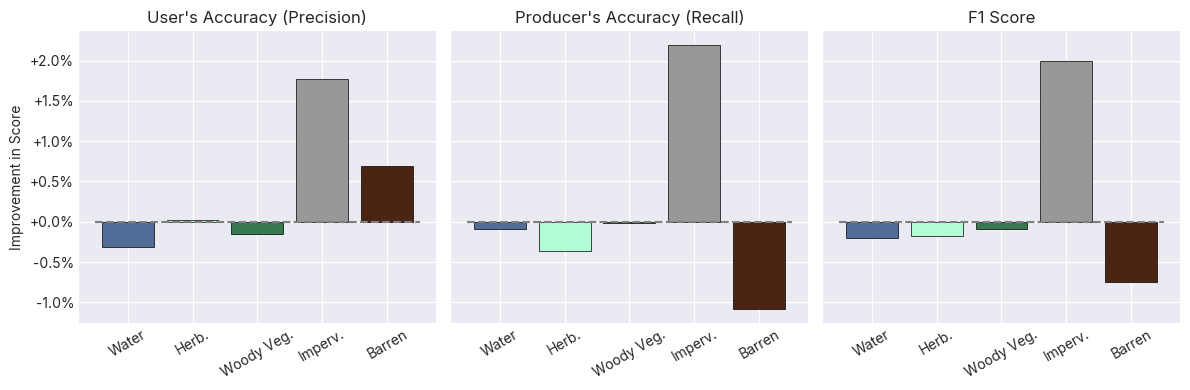

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

linewidth = 0.5
for i, metric in enumerate(['precision', 'recall', 'f1_score']):
    # segformer_data = per_class_metrics_all_df[per_class_metrics_all_df['model'] == 'segformer']
    segformer_data = per_class_metrics_all_df
    s2_data = segformer_data[segformer_data['data'] == 's2']
    s2sr_data = segformer_data[segformer_data['data'] == 's2sr']
    merged_data = pd.merge(
        s2_data,
        s2sr_data,
        on=['class_id', 'fold'],
        suffixes=('_s2', '_s2sr')
    )
    merged_data['f1_diff'] = -( merged_data[f'{metric}_s2'] - merged_data[f'{metric}_s2sr'])
    f1_diff_data = merged_data.groupby('class_id')['f1_diff'].mean().reset_index()
    
    class_labels = {
        1: 'Water',
        2: 'Herb.',
        3: 'Woody Veg.',
        4: 'Imperv.',
        5: 'Barren',
    }
    f1_diff_data['class_label'] = f1_diff_data['class_id'].map(class_labels)

    ax[i].bar(f1_diff_data['class_label'], f1_diff_data['f1_diff'], color=[
        np.array(cpb_colormap_consistent[cid]) / 255.0 for cid in f1_diff_data['class_id']
    ], edgecolor='black', linewidth=linewidth)
    ax[i].hlines(0, -0.5, len(f1_diff_data['class_label']) - 0.5, colors='gray', linestyles='dashed')
    # ax[i].set_title(f'Improvement in {metric} (Super-resolved - Sentinel-2)')
    # rotate x labels
    # plt.xticks(rotation=45, ha='right')
    ax[i].set_xticklabels(f1_diff_data['class_label'], rotation=30, ha='center')

    
    # format y axis as percent
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:+.1%}'.format(y)))
ax[0].set_ylabel('Improvement in Score')

ax[0].set_title('User\'s Accuracy (Precision)')
ax[1].set_title('Producer\'s Accuracy (Recall)')
ax[2].set_title('F1 Score')

fig.tight_layout()

fig_dir = '../figures/per_class_metric_improvements/'
os.makedirs(fig_dir, exist_ok=True)
for filetype in ['png', 'pdf']:
    plt.savefig(os.path.join(fig_dir, f'per_class_metric_improvements.{filetype}'), dpi=300, bbox_inches='tight')

In [21]:
# what is the best performing s2sr model based on macro f1 score?
best_s2sr_models = steps_metrics_df.loc[steps_metrics_df.groupby(['model', 'fold'])['macro_f1'].idxmax()]
best_s2sr_models[['model', 'fold', 'steps', 'macro_f1']]
best_s2sr_models.sort_values(by='macro_f1', ascending=False)

,overall_accuracy,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,mean_iou,cohen_kappa,steps,model,fold
7,0.928878,0.819991,0.761454,0.784511,0.928878,0.928878,0.928878,0.687360,0.847666,1,segformer,2
6,0.928770,0.820471,0.761432,0.784483,0.928770,0.928770,0.928770,0.687258,0.847520,1,segformer,1
5,0.928924,0.817589,0.759718,0.782581,0.928924,0.928924,0.928924,0.685840,0.847692,1,segformer,0
9,0.928774,0.817319,0.756309,0.779923,0.928774,0.928774,0.928774,0.683550,0.847394,1,segformer,4
8,0.928728,0.819457,0.756252,0.779902,0.928728,0.928728,0.928728,0.683497,0.847320,1,segformer,3
1,0.927105,0.821025,0.753230,0.778977,0.927105,0.927105,0.927105,0.681339,0.843422,1,deeplabv3plus,1
3,0.927383,0.832607,0.749011,0.778333,0.927383,0.927383,0.927383,0.681180,0.844022,1,deeplabv3plus,3
0,0.927072,0.826371,0.748854,0.777086,0.927072,0.927072,0.927072,0.680088,0.843329,1,deeplabv3plus,0
12,0.925023,0.816360,0.750604,0.775069,0.925023,0.925023,0.925023,0.677217,0.839085,1,unet,2
2,0.927073,0.820138,0.746255,0.773834,0.927073,0.927073,0.927073,0.677236,0.843261,1,deeplabv3plus,2
